#Preliminary

Imports:

In [ ]:
import math
import random
import numpy as np
import networkx as nx
import networkx.algorithms.cycles as cyc
import networkx.algorithms.dag as dag
import matplotlib.pyplot as plt

#Minimally 3-connected Graph Constructor Implementation

coming soon...

#Implementation of Plestenjak's Planar Graph Drawing Algorithm

In the paper, Plestenjak presents this algorithm to draw planar, 3-connected graphs. It works for other kinds, however, as long as they have at least 1 cycle. The chosen source node for ``` find_cycle()``` would need to be in said cycle, however. Thus, maybe another way for finding a cycle would be better.


In [ ]:
#testing Tutte Graph
G = nx.tutte_graph() #[0, 1, 2, ..., 44, 45]
n = G.number_of_nodes()

#recommended parameters
C = math.sqrt(n / math.pi)
def cool(i):
  return math.sqrt(math.pi / n) / ((1 + (math.pi / n) * i ** (3 / 2)))
 
#actual algorithm, adds the coordinates to each node. We can automate the maxIteration
def PlanarEmbed(G, max, C=C, cool=cool, source=None, outerCycle=None): #default parameters for easy use
    #at the moment, random source and ignore orientation (good)
    if source == None:
        source = random.choice(list(G.nodes)) #since this finds longest path, hamiltonian graphs look uninteresting
    if outerCycle == None:
        outerCycle = cyc.find_cycle(G, source=source)
    #get inner and outer node sets
    outerNodes = [e[0] for e in outerCycle]
    innerNodes = [v for v in G.nodes if not v in outerNodes]
 
    #step 1
    q = len(outerNodes)
    for i in range(q): #for outer nodes, unit circle coordinates
        v = outerNodes[i]
        angle = (2 * math.pi * i) / q
        x, y = math.cos(angle), math.sin(angle)
        G.nodes[v]["position"] = np.array([x, y], dtype=float)
 
    for v in innerNodes: #for inner nodes, zero vector coordinate
        G.nodes[v]["position"] = np.zeros(2, dtype=float)
 
    #step 2
    for i in range(max):
        for v in G.nodes: #a: set the force to 0 for all v
            G.nodes[v]["force"] = np.zeros(2, dtype=float)
        
        for e in G.edges: #b: adjust force for inner and outer v
            u = e[0]
            v = e[1]
            posv = G.nodes[v]["position"]
            posu = G.nodes[u]["position"]
            F = C * np.power((posv - posu), 3)
            G.nodes[u]["force"] += F
            G.nodes[v]["force"] -= F
        
        for v in innerNodes: #c: move coordinates for inner v
            F = G.nodes[v]["force"]
            d = np.linalg.norm(F)
            if (d > 0): #avoids div by 0, not all inner are neighbors to outers
                displacement = (min([d, cool(i)]) / d)
                G.nodes[v]["position"] += displacement * F 
 
def PlotGraph(G, s=None, t=None):
    for e in G.edges:
        color = "black"
        u = e[0]
        v = e[1]
        if (u == s or v == s or u == t or v == t):
            color = "red"
        pos1 = G.nodes[u]["position"]
        pos2 = G.nodes[v]["position"]
        x1, x2 = pos1[0], pos2[0]
        y1, y2 = pos1[1], pos2[1]
        plt.plot([x1, x2], [y1, y2], 'go-', color=color, markersize=2.7, linewidth=1)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

def PlotDirectedGraph(G, s, t):
    for e in G.edges:
        u = e[0]
        v = e[1]
        color = "blue"
        if (u == s or v == t):
            color = "red"
        pos1 = G.nodes[u]["position"]
        pos2 = G.nodes[v]["position"]
        x1, x2 = pos1[0], pos2[0]
        y1, y2 = pos1[1], pos2[1]
        plt.plot(x1, y1, "go--", markersize=2.7, color=color, label=u)
        plt.plot(x2, y2, "go--", markersize=2.7, color=color, label=v)
        plt.arrow(x1, y1, x2-x1, y2-y1, 
                  color="black",
                  length_includes_head=True,
                  linewidth=0.5,
                  head_width=0.03, 
                  head_length=0.05)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

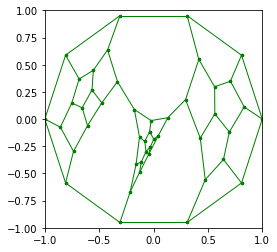

In [ ]:
PlanarEmbed(G, 256)
PlotGraph(G)

Since the function ```find_cycle()``` finds the longest cycle starting from the source, hamiltonian graphs produce uninteresting embeddings due to **every** vertex being in the outer unit circle. This likely produces a self-intersecting embedding of a planar graph.

For example, the embedding of the dodecahedral graph:

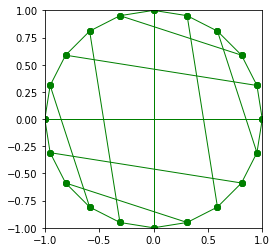

#Implementation of Papamanthou-Tollis Parameterized st-Orientation Generator

This is an implementation of the standard STN, where ```choose()``` is a random sampling

choose functions

In [ ]:
def choose_standard(pool):
    return pool

def choose_max(pool):
    global m
    if not pool: #if pool empty return empty set
        return set()
    weights = [m[v] for v in pool]
    max_weight = max(weights)
    return {v for v in pool if m[v] == max_weight}

def choose_min(pool):
    global m
    if not pool: #if pool empty return empty set
        return set()
    weights = [m[v] for v in pool if m[v] != -1] 
    min_weight = min(weights)
    return {v for v in pool if m[v] == min_weight}

Base Algorithm

In [ ]:
def UpdateBlocks(G):
    global t

    T = nx.DiGraph()

    cut_points = list(nx.articulation_points(G))
    blocks = [tuple(x) for x in nx.biconnected_components(G)]

    root = None
    for b in blocks:
        if t in b:
            root = b

    T.add_node(root)

    block_stack = []
    processed_blocks = []
    processed_nodes = []
    block_stack.append(root)

    while (block_stack):
        r = block_stack.pop()

        processed_blocks.append(r)
        cut_point_children = [cp for cp in r if cp in cut_points and not cp in processed_nodes]

        for cp in cut_point_children:
            T.add_node(cp)
            T.add_edge(r, cp)

            processed_nodes.append(cp)
            block_children = [b for b in blocks if cp in b and not b in processed_blocks]

            for b in block_children:
                T.add_node(b)
                T.add_edge(cp, b)

                block_stack.append(b)

    #nx.draw_networkx(T, arrows=True)
    return T

def STREC(G, v, choose, p):
    global F, j, Q, m, f, N, t

    j = j+1
    f[v] = j #assuming vertex labels are ints
    
    neighbors = list(G.neighbors(v))

    F.add_node(v)
    [F.add_edge(v, n) for n in neighbors]
    G.remove_node(v)

    Q = Q.union({n for n in neighbors if n != t})
    Q.discard(v)

    for n in neighbors:
        m[n] = j

    if not Q:
        f[t] = n
        return

    else:
        T = UpdateBlocks(G)
        leaf_blocks = [node for node in T.nodes if T.out_degree(node)==0]

        for block in leaf_blocks:
            predecessors = list(T.predecessors(block))

            if not predecessors: #no predecessors, G is still biconnected
                pool = Q.intersection(set(block))
            else:
                pred = predecessors[0]
                pool = Q.intersection(set(block))
                pool.discard(pred)

            if pool:
                choice = random.choice(list(choose(pool)))

                #here lies the parametrization
                if p == -1:
                    STREC(G, choice, choose, -1)
                elif j < p * N:
                    #print(f"max j: {j}, p: {p}, N: {N}, pn: {p*N}")
                    STREC(G, choice, choose_max, p)
                else:
                    #print(f"min j: {j}, p: {p}, N: {N}, pn: {p*N}")
                    STREC(G, choice, choose_min, p)

STN variants

In [ ]:
def STN(G, s, choose=choose_standard, p=-1):
    if (not nx.is_biconnected(G)):
        return
    STREC(G, s, choose, p)

def MAX_STN(G, s):
    STN(G, s, choose=choose_max, p=1)

def MIN_STN(G, s):
    STN(G, s, choose=choose_min, p=0)

def PAR_STN(G, s, p):
    STN(G, s, choose=choose_max, p=p)

Assignments



In [ ]:
#example tutte graph
G = nx.tutte_graph()
N = G.number_of_nodes()

longest cycle: [(0, 1), (1, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 2), (2, 0)]
t: 22
s: 9


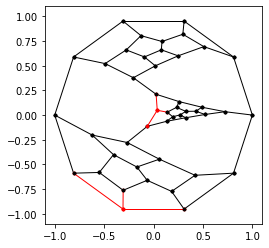

In [514]:
#find the biggest cycle in G
all_loops = [list(nx.find_cycle(G, source=v)) for v in G.nodes]

a = sorted(all_loops, key = lambda s: len(s)) 
longest_cycle = a[-1]
print(f"longest cycle: {longest_cycle}")

#find node nearest to center of embedding
PlanarEmbed(G, 256, source=0, outerCycle=longest_cycle)
coordinates = [(v, G.nodes[v]["position"]) for v in G.nodes]

b = sorted(coordinates, key = lambda c: np.linalg.norm(c[1])) 
closest_to_origin = b[0][0]

#make this node t
t = closest_to_origin
print(f"t: {t}")

#select a node farthest from t in longest cycle to be s. 
s = random.choice(longest_cycle)[0] #change this random sampling
print(f"s: {s}")

PlotGraph(G, s=s, t=t)


Execution 

---
`PAR_STN` implemented, fully working

In [515]:
#Execution: create st-orientation of G
Q = {s}
m = np.full(G.number_of_nodes(), 0, dtype=int)
f = np.full(G.number_of_nodes(), 0, dtype=int)
j = 0
F = nx.DiGraph()

G1 = G.copy()
PAR_STN(G1, s, 0.5) #change the parameter p here

print(f"s, t: {s}, {t}")
print(f"st-numbering: {f}")
print(f"G number of nodes, edges: {G.number_of_nodes()}, {G.number_of_edges()}")
print(f"F number of nodes, edges: {F.number_of_nodes()}, {F.number_of_edges()}")

s, t: 9, 22
st-numbering: [25 28  8 29 31 30 27 14  2  1  7  9 10 15 13 16 17 20 21 32 33 45 22 44
 43 40 35 34 38 37 39 41 42 36 12 11  5  4  3  6 26 24 23 19 18 22]
G number of nodes, edges: 46, 69
F number of nodes, edges: 46, 69


Visualization 


---


Working! Sink t isnt uniquely colored since plotting uses edges. Now always with longest possible outer face.

A change: since we embedded G earlier, we use it to embed F for free

s, t: 9, 22
is DAG: True
longest path (length 25): [9, 8, 38, 37, 36, 39, 10, 2, 11, 12, 35, 34, 14, 13, 15, 16, 44, 43, 17, 18, 45, 42, 41, 20, 21, 22]
shortest path (length 7): [9, 8, 7, 6, 27, 23, 21, 22]
source: [9]
sink: [22]


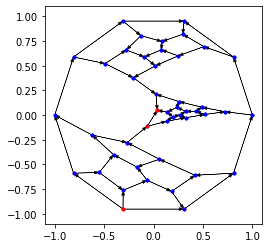

In [516]:
for v in G.nodes:
    for attribute in G.nodes[v]:
        F.nodes[v][attribute] = G.nodes[v][attribute] #set the embed attributes in directed graph

PlotDirectedGraph(F, s, t) #plot directed graph

longest_path = dag.dag_longest_path(F)
shortest_path = nx.shortest_path(F, source=s, target=t)

print(f"s, t: {s}, {t}")
print(f"is DAG: {nx.is_directed_acyclic_graph(F)}")
print(f"longest path (length {len(longest_path)-1}): {longest_path}")
print(f"shortest path (length {len(shortest_path)-1}): {shortest_path}")
print(f"source: {[v for v in F.nodes if F.in_degree(v)==0]}")
print(f"sink: {[v for v in F.nodes if F.out_degree(v)==0]}")

#References


 
---
 
B. Plestenjak, 'An Algorithm for Drawing Planar Graphs' https://www.fmf.uni-lj.si/~plestenjak/Papers/schlegel
 
C. Papamanthou, I. G. Tollis, 'Algorithms for computing a parameterized st-orientation' https://www.researchgate.net/publication/220149886_Algorithms_for_computing_a_parameterized_st-orientation

J. P. Costalonga et al, 'Constructing minimally 3-connected graphs' https://arxiv.org/abs/2012.12059